In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
import sys
import os
sys.path.append(os.path.join('..', '..', '..' ))

from shared.cifar10_dvs_dataset import CIFAR10DVSData

data_handler = CIFAR10DVSData(save_to='../../../shared/datasets')
data_handler.check_and_download()

train_dataloader, val_dataloader, test_dataloader = data_handler.get_frame_dataloader(batch_size=128, train_ratio=0.7)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAR10DVS Data handler initialized. Data will be saved to '../../../shared/datasets'
Download check complete.
Splited dataset into:
 - Training set: 7000 samples
 - Validation set: 1500 samples
 - Test set: 1500 samples


Shape of a frame-based data batch: torch.Size([128, 1, 32, 32])
Labels of the batch: tensor([7, 5, 1, 2, 6, 1, 4, 0, 2, 7, 3, 9, 3, 1, 8, 9, 5, 1, 5, 5, 0, 6, 2, 1,
        9, 0, 1, 1, 4, 8, 2, 0, 8, 0, 4, 6, 4, 7, 3, 0, 7, 3, 8, 1, 2, 9, 7, 0,
        4, 9, 9, 8, 6, 9, 3, 8, 0, 6, 8, 1, 1, 7, 1, 6, 5, 6, 9, 1, 6, 4, 9, 9,
        3, 8, 4, 8, 7, 1, 6, 1, 4, 0, 3, 6, 0, 3, 7, 0, 9, 3, 8, 7, 5, 0, 0, 0,
        6, 7, 6, 3, 9, 3, 3, 8, 2, 1, 0, 9, 1, 0, 2, 4, 3, 1, 1, 6, 4, 0, 9, 5,
        2, 0, 1, 0, 2, 1, 3, 4])


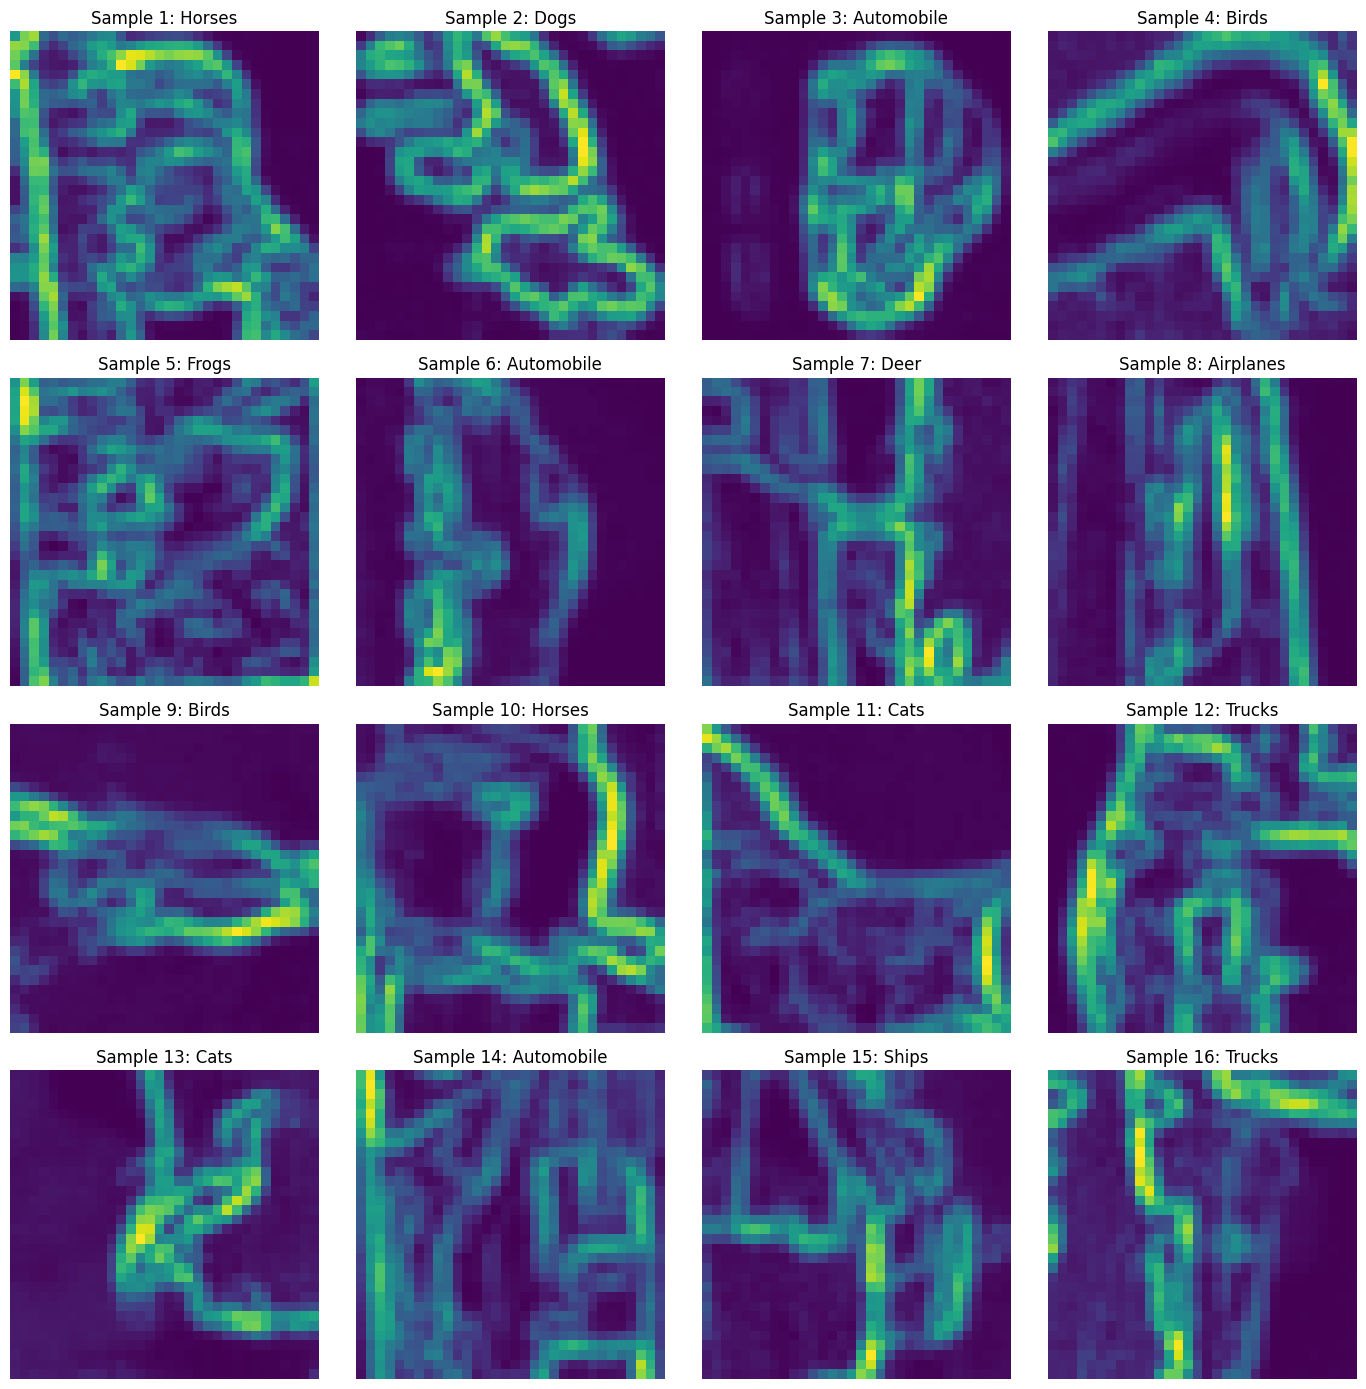

In [3]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
samples, labels = next(iter(train_dataloader))
print(f"Shape of a frame-based data batch: {samples.shape}")
print(f"Labels of the batch: {labels}")


batch_size = samples.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # For batch_size=16
axes = axes.flatten()

for i in range(16):
    sample_img = samples[i, 0]  # shape: [H, W]
    ax = axes[i]
    ax.imshow(sample_img)
    label_index = labels[i].item()
    label_name = data_handler.labels[label_index]
    ax.set_title(f"Sample {i+1}: {label_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
import torch.nn as nn

vgg9_model = nn.Sequential(
    # Feature extractor
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 10),
)

In [8]:
vgg9_model.to(device)
print(vgg9_model)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=256, bias=True)
  (15): ReLU(inplace=True)
  (16): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
total_params = sum(p.numel() for p in vgg9_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1605578


In [10]:
from shared.early_stopping import EarlyStopping
from shared.system_monitor import SystemMonitor

monitor = SystemMonitor(sample_interval=1.0)

# Define training rules
optimizer = torch.optim.Adam(vgg9_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, delta=0.01)

In [11]:
from shared.pytorch_trainer import Trainer

trainer = Trainer(
    model=vgg9_model,
    train_loader=train_dataloader,  
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    early_stopping=early_stopping)

In [12]:
monitor.start()

trainer.train(num_epochs=100, log_interval=10)

monitor.stop()

System monitor started.
Starting training...
Train Epoch: 1 [1152/7000 (16%)]	Loss: 2.302956
Train Epoch: 1 [2432/7000 (35%)]	Loss: 2.184484
Train Epoch: 1 [3712/7000 (53%)]	Loss: 2.069839
Train Epoch: 1 [4992/7000 (71%)]	Loss: 1.934707
Train Epoch: 1 [6272/7000 (89%)]	Loss: 1.967543
Epoch 1 Summary -> Train Loss: 2.1351, Val Loss: 1.9517

Train Epoch: 2 [1152/7000 (16%)]	Loss: 1.995891
Train Epoch: 2 [2432/7000 (35%)]	Loss: 1.861357
Train Epoch: 2 [3712/7000 (53%)]	Loss: 1.815864
Train Epoch: 2 [4992/7000 (71%)]	Loss: 1.761171
Train Epoch: 2 [6272/7000 (89%)]	Loss: 1.787406
Epoch 2 Summary -> Train Loss: 1.8967, Val Loss: 1.8362

Train Epoch: 3 [1152/7000 (16%)]	Loss: 1.772037
Train Epoch: 3 [2432/7000 (35%)]	Loss: 1.747610
Train Epoch: 3 [3712/7000 (53%)]	Loss: 1.593750
Train Epoch: 3 [4992/7000 (71%)]	Loss: 1.568233
Train Epoch: 3 [6272/7000 (89%)]	Loss: 1.804255
Epoch 3 Summary -> Train Loss: 1.7211, Val Loss: 1.7650

Train Epoch: 4 [1152/7000 (16%)]	Loss: 1.415995
Train Epoch: 4 [

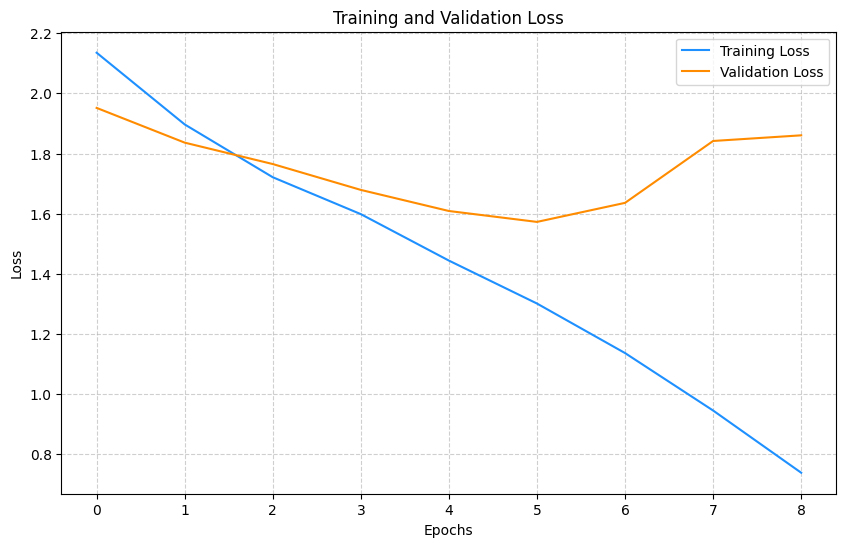

In [13]:
trainer.plot_learning_curve()


--- Test Set Evaluation ---
Average loss: 1.8396, Accuracy: 708/1500 (47.20%)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       134
           1       0.51      0.47      0.49       135
           2       0.35      0.31      0.33       144
           3       0.32      0.24      0.28       131
           4       0.38      0.61      0.46       157
           5       0.53      0.41      0.46       158
           6       0.52      0.60      0.56       167
           7       0.56      0.56      0.56       170
           8       0.40      0.54      0.46       140
           9       0.68      0.47      0.55       164

    accuracy                           0.47      1500
   macro avg       0.48      0.47      0.46      1500
weighted avg       0.49      0.47      0.47      1500


Confusion Matrix:


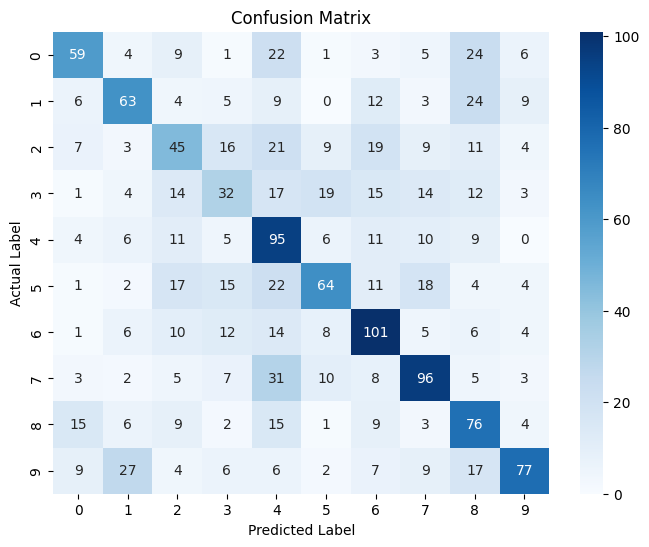

In [14]:
trainer.evaluate(test_dataloader)

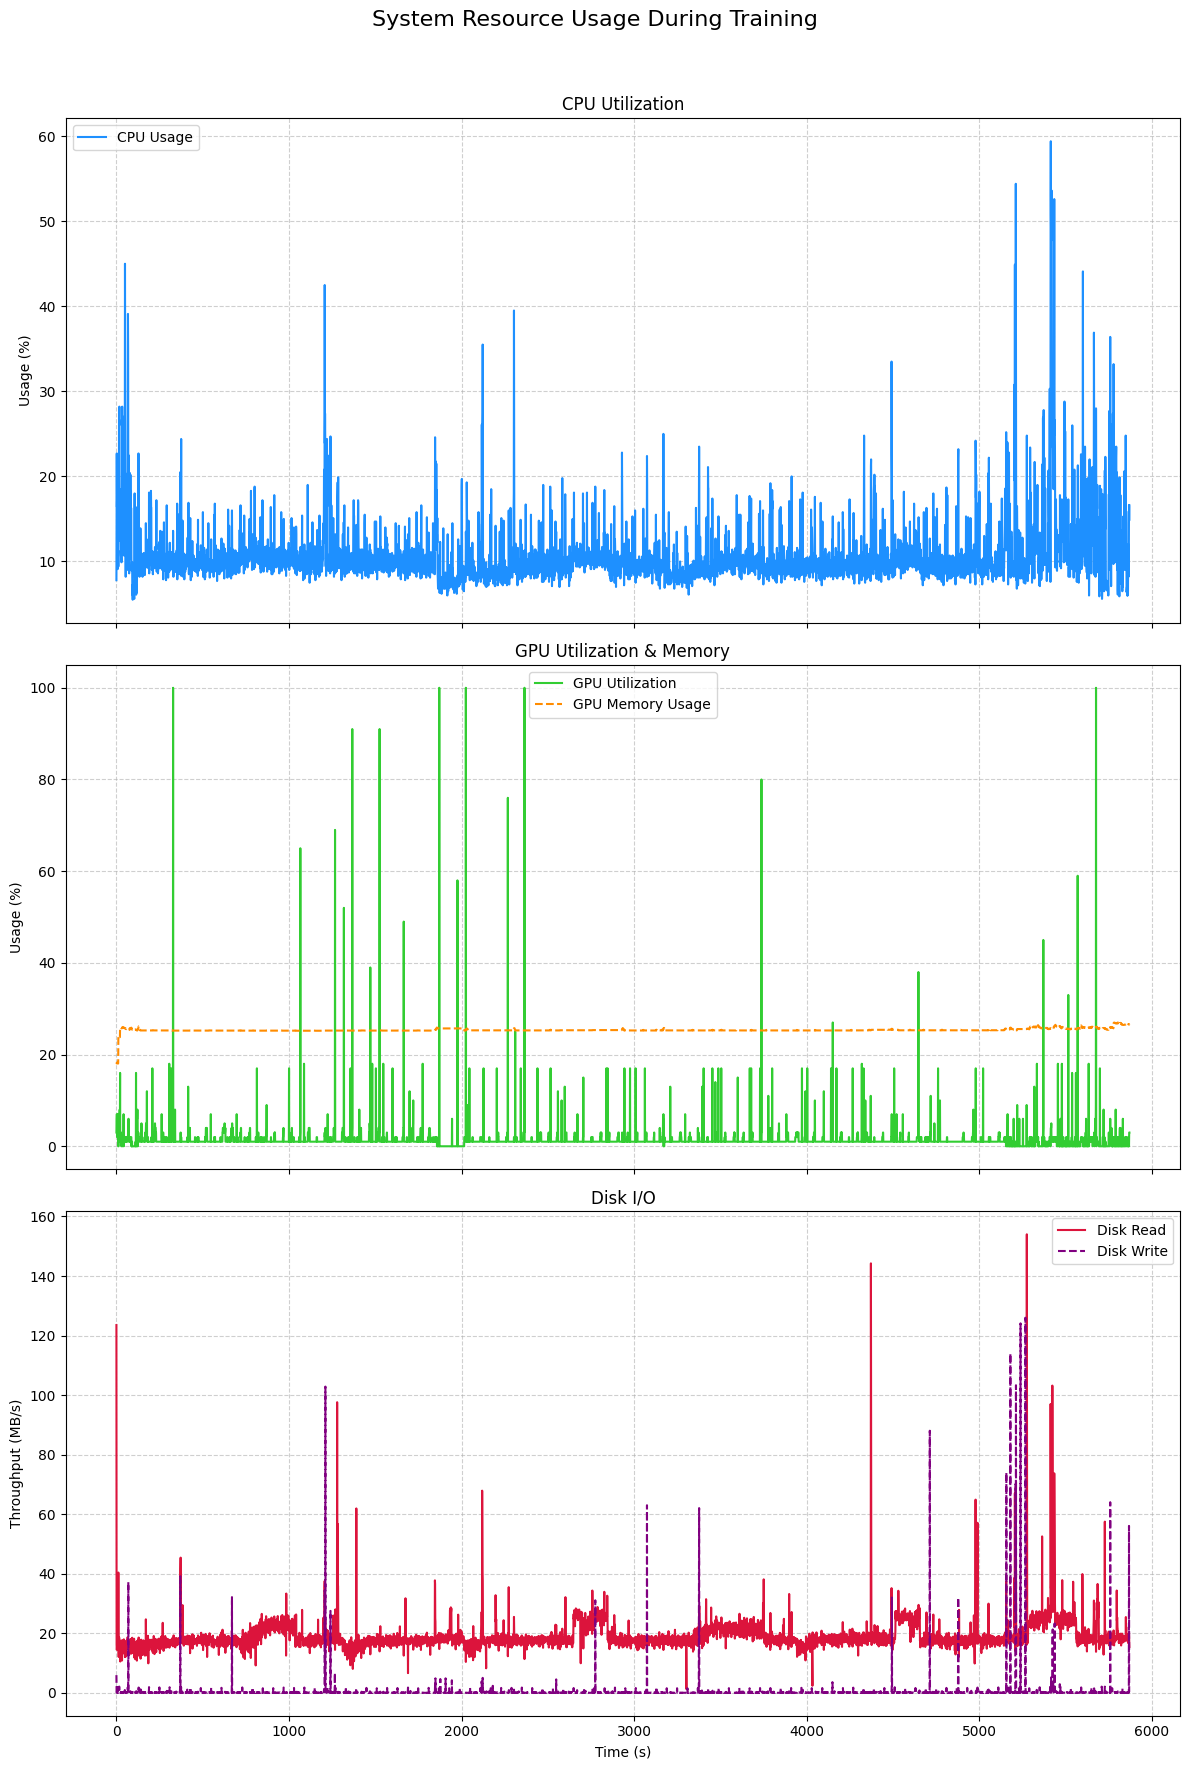

In [15]:
monitor.plot_results()

In [16]:
import onnx
sample, _ = next(iter(train_dataloader))
sample = sample.to(device)
torch.onnx.export(vgg9_model,
                  sample,
                  f="pytorch_cifar10_dvs_sequential.onnx",
                  input_names=["inputs"],
                  output_names=["outputs"],
                  dynamic_axes={'inputs': {0: 'batch_size'}, 'outputs': {0: 'batch_size'}})

In [17]:
from quantizeml.models import quantize

# Read the exported ONNX model
model_onnx = onnx.load_model("pytorch_cifar10_dvs_sequential.onnx")

# Extract a batch of train samples for calibration
calib_samples = next(iter(train_dataloader))[0].numpy()

# Quantize
model_quantized = quantize(model_onnx, samples=calib_samples)
print(onnx.helper.printable_graph(model_quantized.graph))

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\onnxscript\converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Applied 3 of general pattern rewrite rules.
Calibrating with 128/128.0 samples
graph main_graph (
  %inputs[FLOAT, batch_sizex1x32x32]
) initializers (
  %quantize_scale[FLOAT, 1]
  %quantize_zp[UINT8, 1]
  %/0/Conv_Xpad[UINT8, 1]
  %/0/Conv_Wi[INT8, 64x1x3x3]
  %/0/Conv_B[INT32, 64]
  %/0/Conv_pads[INT64, 8]
  %/0/Conv_M[UINT8, 1x64x1x1]
  %/0/Conv_S_out[FLOAT, 1x64x1x1]
  %/2/Conv_Wi[INT8, 64x64x3x3]
  %/2/Conv_B[INT32, 64]
  %/2/Conv_pads[INT64, 8]
  %/2/Conv_M[UINT8, 1x64x1x1]
  %/2/Conv_S_out[FLOAT, 1x64x1x1]
  %/5/Conv_Wi[INT8, 128x64x3x3]
  %/5/Conv_B[INT32, 128]
  %/5/Conv_pads[INT64, 8]
  %/5/Conv_M[UINT8, 1x128x1x1]
  %/5/Conv_S_out[FLOAT, 1x128x1x1]
  %/7/Conv_Wi[INT8, 128x128x3x3]
  %/7/Conv_B[INT32, 128]
  %/7/Conv_pads[INT64, 8]
  %/7/Conv_M[UINT8, 1x128x1x1]
  %/7/Conv_S_out[FLOAT, 1x128x1x1]
  %/10/Conv_Wi[INT8, 256x128x3x3]
  %/10/Conv_B[INT32, 256]
  %/10/Conv_pads[INT64, 8]
  %/10/Conv_M[UINT8, 1x256x1x1]
  %/10/Conv_S_out[FLOAT, 1x256x1x1]
  %/14/Gemm_Wi[INT8, 256x4

In [ ]:
from onnxruntime import InferenceSession


def evaluate_onnx_model(model):
    sess = InferenceSession(model.SerializeToString())
    # Calculate outputs by running images through the session
    outputs = sess.run(None, {model.graph.input[0].name: x_test})
    # The class with the highest score is what we choose as prediction
    predicted = np.squeeze(np.argmax(outputs[0], 1))
    # Compute the number of valid predictions
    return int((predicted == labels_test).sum())


# Evaluate over test dataset
correctly_classified_floating = evaluate_onnx_model(onnx_model)
print(f'Floating point model accuracy: {correctly_classified_floating}/{num_images}.')

In [ ]:
correctly_classified = evaluate_onnx_model(model_quantized)
print(f'Quantized model accuracy: {correctly_classified}/{num_images}.')

In [18]:
from cnn2snn import convert

model_akida = convert(model_quantized)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[32, 32, 1]  [1, 1, 10]    1          8     
______________________________________________

____________________________________________________________
Layer (type)               Output shape   Kernel shape    

============= SW//0/Conv-dequantizer (Software) ============

/0/Conv (InputConv2D)      [32, 32, 64]   (3, 3, 1, 64)   
____________________________________________________________
/2/Conv (Conv2D)           [16, 16, 64]   (3, 3, 64, 64)  
____________________________________________________________
/5/Conv (Conv2D)           [16, 16, 128]  (3, 3, 64, 128) 
____________________________________________________________
/7/Conv (Conv2D)           [8, 8, 128]    (3, 3, 128, 128)
____________________________________________________________
/10/Conv (Conv2D)          [4, 4, 256]    (3, 3, 128, 256)
______________________________________________

In [23]:
accuracy = []

for x_test_batch, y_test_batch in test_dataloader:
    # Transpose from (batch, 1, 32, 32) to (batch, 32, 32, 1)
    x_test_batch = x_test_batch.numpy().transpose(0, 2, 3, 1)
    # Convert to uint8 if needed
    x_test_batch = x_test_batch.astype('uint8')
    # Now you can evaluate this batch
    accuracy.append(model_akida.evaluate(x_test_batch, y_test_batch, num_classes=10, batch_size=128))

In [24]:
print(f'Overall accuracy: {(sum(accuracy) / len(accuracy)) * 100:.2f}%')

Overall accuracy: 9.50%
